In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load data
data = pd.read_csv('../data/data.csv')
data['DATE'] = pd.to_datetime(data['DATE'], format="%Y-%m-%d")
data.set_index('DATE', inplace=True)

# Prepare the temperature data
temp = data['TEMP'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(temp)

In [3]:
# Convert the time series to a supervised learning problem
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X, y = create_dataset(temp_scaled, time_step)

In [4]:
# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
random.seed(666)
model.fit(X, y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


d:\Programs\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2385   
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.0079
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0068
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0059
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0056
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0051
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0052
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.0048
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0044
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0043
Epoch 13/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.0042
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.0042
Epoch 15/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

In [5]:
# Make predictions
random.seed(666)
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [9]:
# Calculate metrics for temperature prediction
mse_temp = mean_squared_error(temp[:len(train_predict)], train_predict)
mae_temp = mean_absolute_error(temp[:len(train_predict)], train_predict)
r2_temp = r2_score(temp[:len(train_predict)], train_predict)

print(f"Temperature Prediction - MSE: {mse_temp}, MAE: {mae_temp}, R²: {r2_temp}")

Temperature Prediction - MSE: 81.8442190808256, MAE: 7.0721780647660415, R²: 0.8484580631480387


In [10]:
# Function to calculate AIC and BIC
def calculate_aic_bic(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    n = X.shape[0]  # number of samples
    k = model.count_params()  # number of parameters
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)
    return aic, bic

In [11]:
# Calculate AIC and BIC for temperature prediction
aic_temp, bic_temp = calculate_aic_bic(model, X, y)
print(f"Temperature Prediction - AIC: {aic_temp}, BIC: {bic_temp}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
Temperature Prediction - AIC: -6839.249003283934, BIC: 8228.67440837586


In [14]:
# Forecast further 365 days
def forecast_future(model, last_data, steps):
    predictions = []
    current_data = last_data
    for _ in range(steps):
        pred = model.predict(current_data.reshape(1, -1, 1))
        predictions.append(pred[0, 0])
        current_data = np.append(current_data[1:], pred)
    return np.array(predictions)

random.seed(666)
last_data_temp = temp_scaled[-time_step:]
future_predictions_temp_scaled = forecast_future(model, last_data_temp, 365)
future_predictions_temp = scaler.inverse_transform(future_predictions_temp_scaled.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

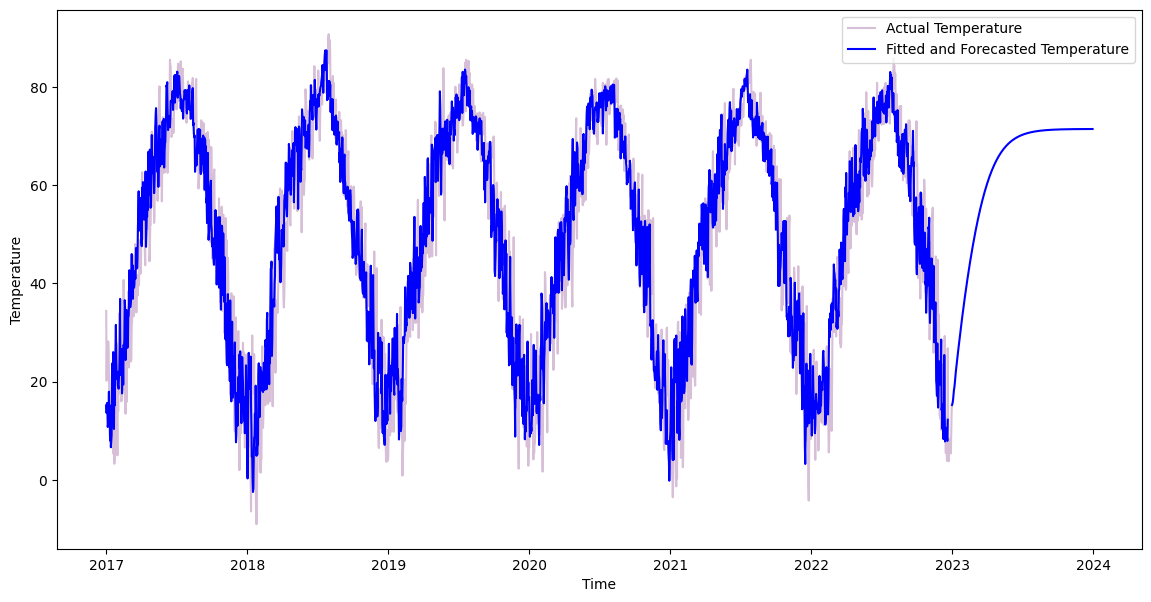

In [24]:
# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(data.index, temp, label='Actual Temperature', color='thistle', linestyle='-')
plt.plot(data.index[:len(train_predict)], train_predict, label='Fitted and Forecasted Temperature', color="blue")
future_dates = pd.date_range(start=data.index[-1], periods=365, freq='D')
plt.plot(future_dates, future_predictions_temp, color='blue')
plt.xlabel('Time')
plt.ylabel('Temperature')
# plt.title('Temperature Fitting and Forecast')
plt.legend(loc = 'upper right')
plt.savefig('../fig/dnn_pred_365.png')
plt.show()